In [47]:
DATA_PATH = 'C:/Gel_Sheet_Data/'
MOVIE_PATH = DATA_PATH +'movie60/'
GRAPH_PATH = 'C:/Gel_Sheet_Graph/'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from  skimage.filters import gaussian
from tqdm.notebook import trange, tqdm
import movie_structure
import autocorrelation_and_structure_factor_IK_20220103 as iac

In [48]:
gel = np.load(MOVIE_PATH +'np/gel.npy', mmap_mode='r')


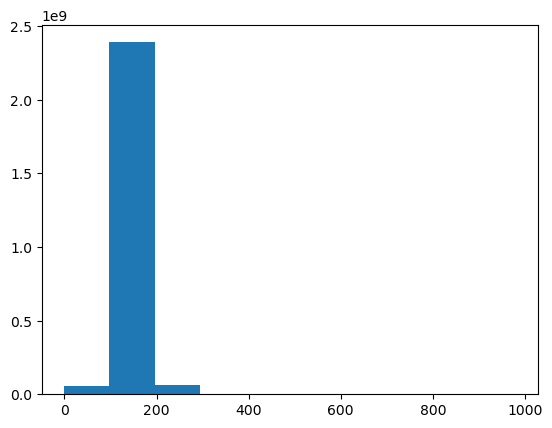

In [49]:
flat = gel.reshape(-1)
plt.hist(flat)
plt.show()

In [3]:
np.min(gel)
np.max(gel)

979.0

In [ ]:
flat = np.array(flat)
flat = np.array([flat[flat<300]])
flat = np.array([flat[flat>100]])
plt.hist(flat)
plt.show()

In [ ]:
flat = gel.reshape(-1).copy()
flat[flat>140] = np.nan
flat[flat<00] = np.nan

plt.figure()
plt.hist(flat[~np.isnan(flat)], bins = 100)
plt.show()

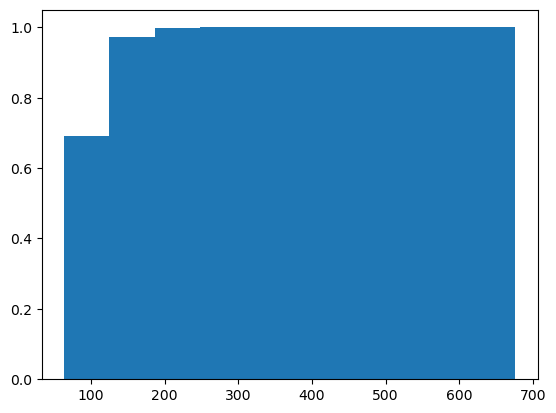

In [50]:
flat = gel[17].reshape(-1)[1:-1:10]
n, bins, patches = plt.hist(flat,cumulative=True, density=True)
plt.show()

In [51]:
min_intensity = bins[1]
max_intensity = 10000

threshold_gel = gaussian(gel[17],3)
threshold_gel[threshold_gel<min_intensity] =0
threshold_gel[threshold_gel>max_intensity] = 0
threshold_gel[np.bitwise_and(threshold_gel>= min_intensity , threshold_gel<= max_intensity)] =1

# np.save(DATA_PATH + 'tmp/t_gel.npy', threshold_gel)



C:\Users\amityu\Anaconda3\lib\site-packages\napari\_qt\__init__.py:53: UserWarning: 

napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with
this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


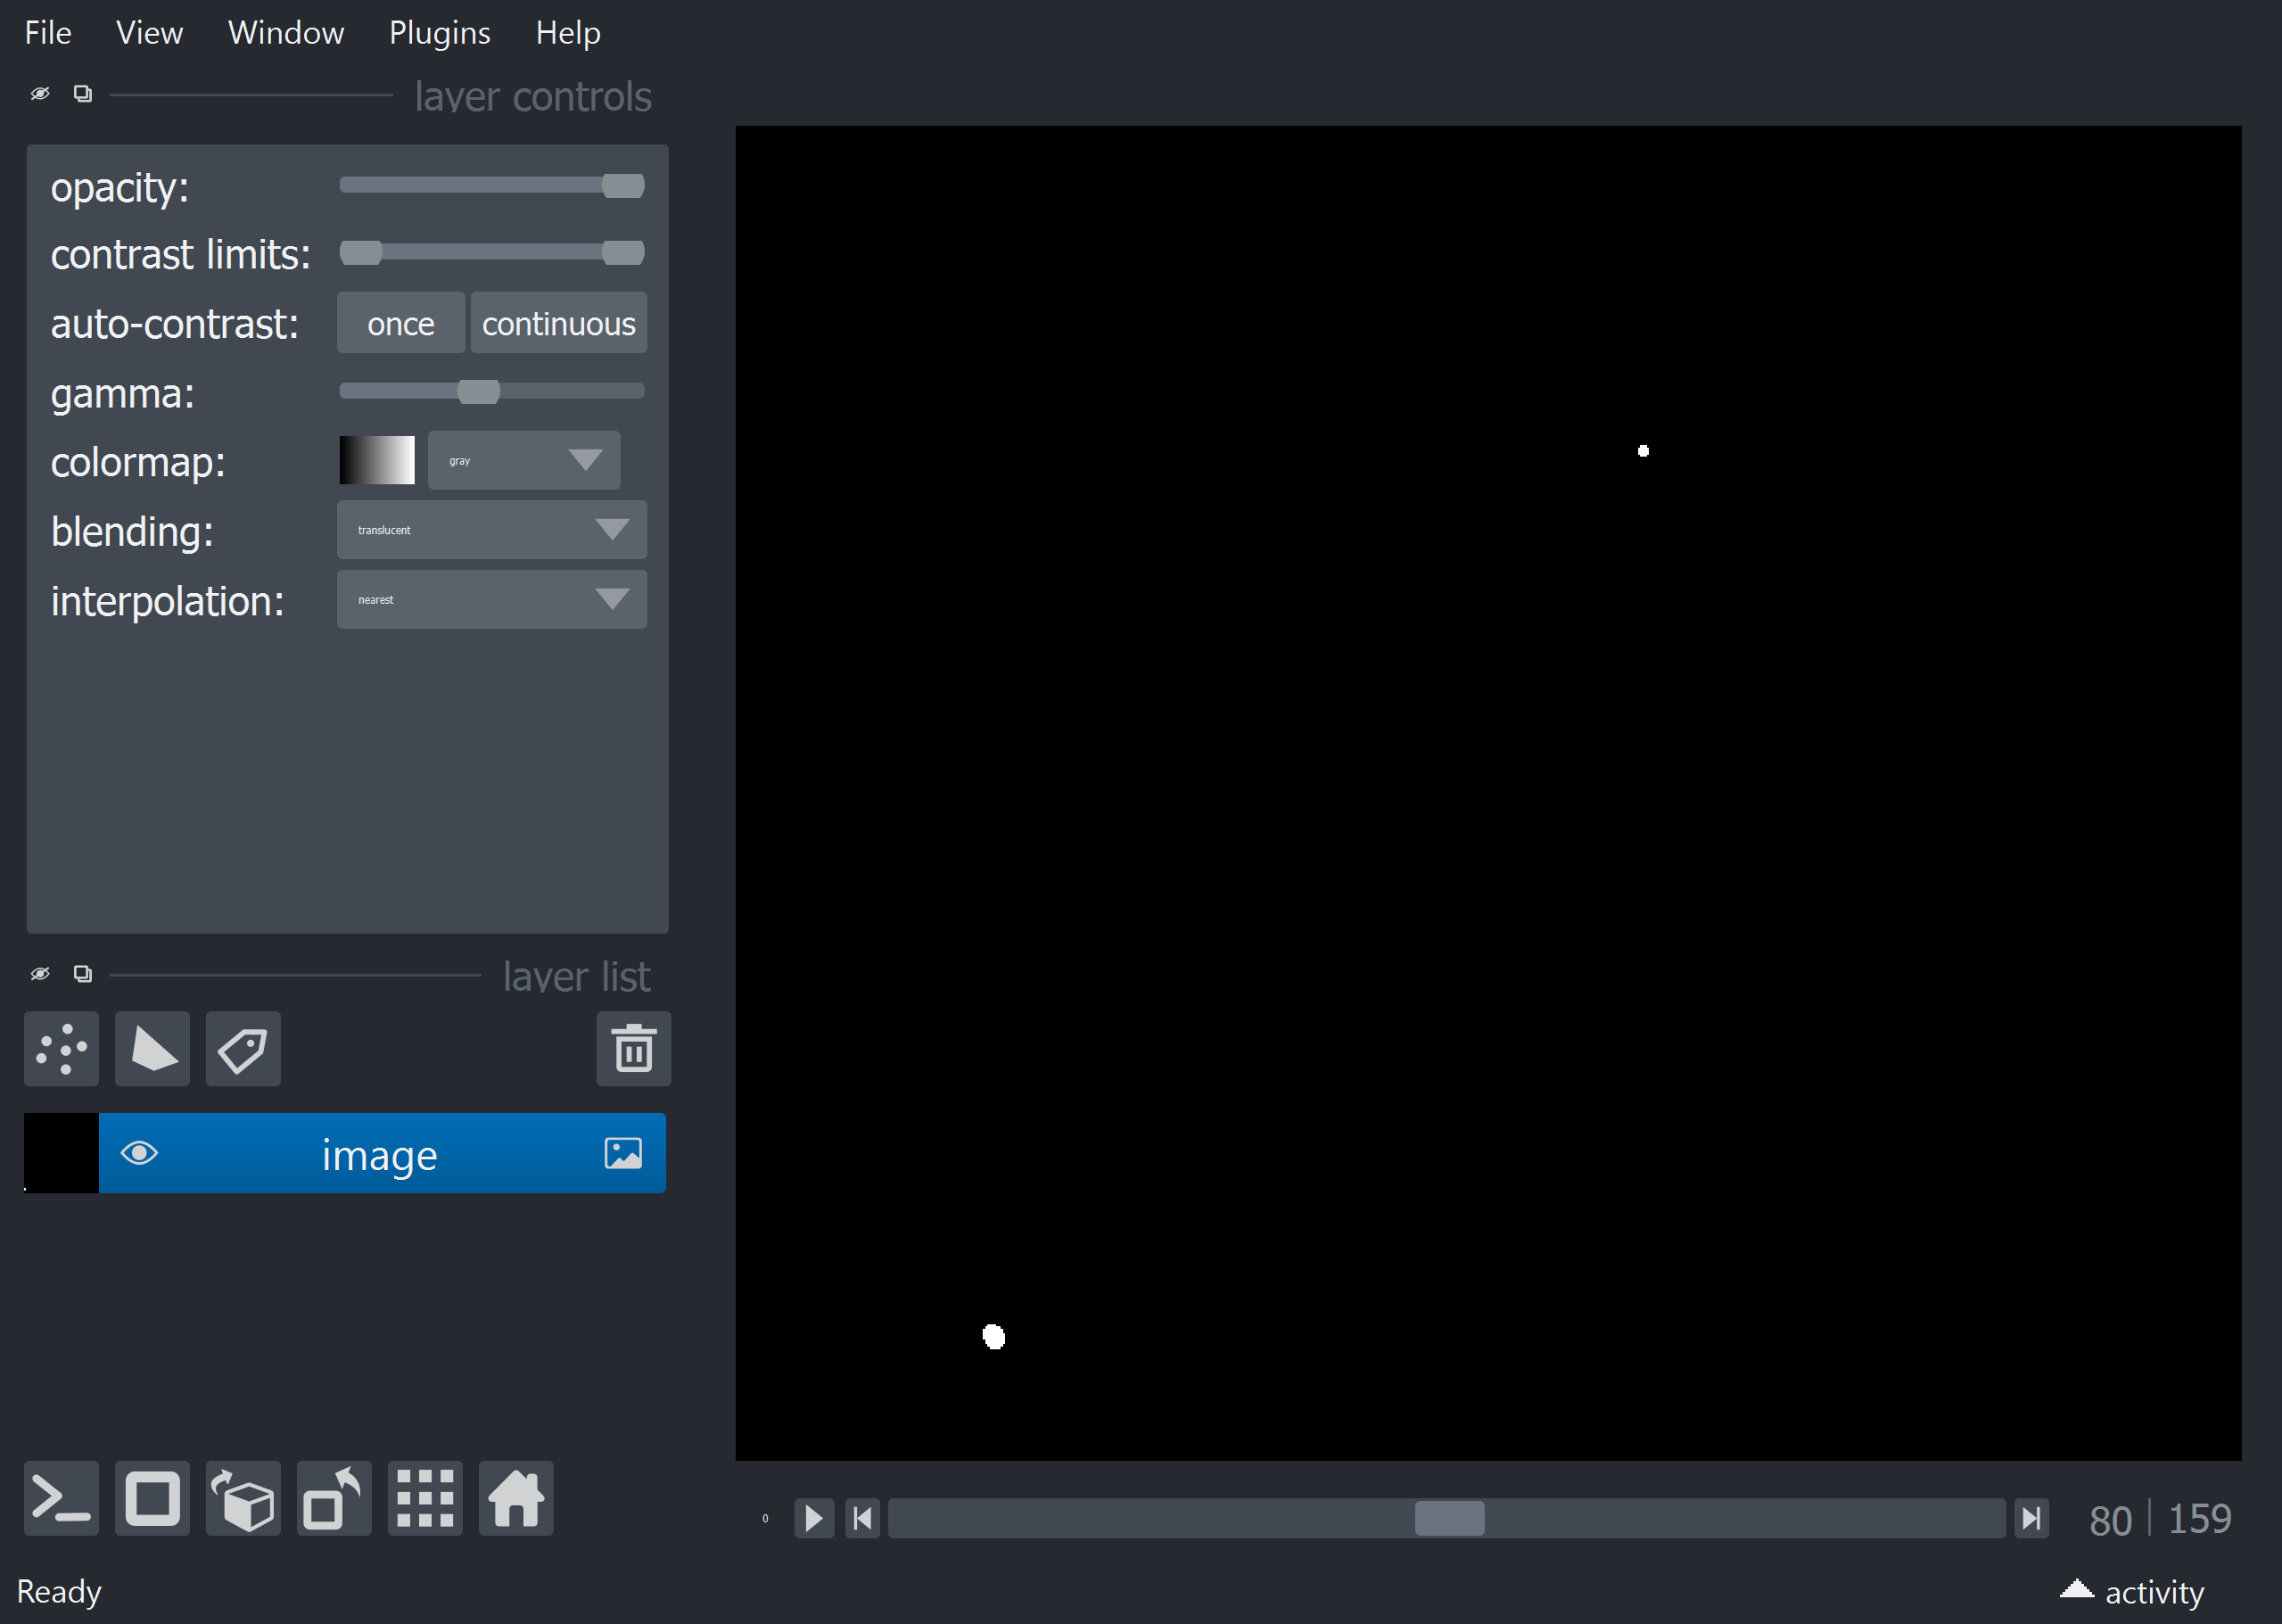

In [52]:
import napari
viewer = napari.Viewer()
image = threshold_gel
viewer.add_image(image)
napari.utils.nbscreenshot(viewer)

In [36]:
viewer.add_image(threshold_gel)


<Image layer 'threshold_gel' at 0x1b58ad47610>

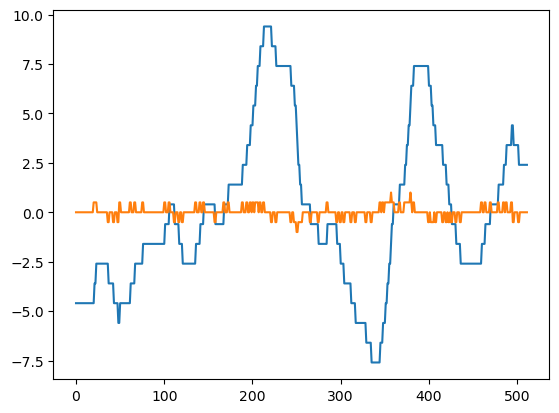

In [6]:
import movie_structure
plane = movie_structure.Vplane(threshold_gel[:,:,256], threshold_gel[:,:,256])
height = plane.set_height()
mean = np.mean(height)
height_difference = height - mean
plt.plot (height_difference)
plt.plot(np.gradient(height))
plt.show()
print()

  0%|          | 0/60 [00:00<?, ?it/s]

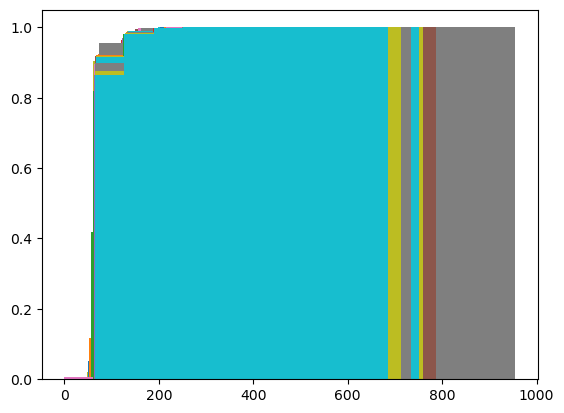

In [53]:
gradient_table = np.zeros((len(gel), gel.shape[2]))
height_table = np.zeros((len(gel), gel.shape[2]))

for t in trange(len(gel)):
    flat = gel[t].reshape(-1)[1:-1:10]
    n, bins, patches = plt.hist(flat,cumulative=True, density=True)
    min_intensity = bins[1]
    max_intensity = 10000

    gel_time_point = gaussian(gel[t],3)
    gel_time_point[gel_time_point < min_intensity] =0
    gel_time_point[gel_time_point>max_intensity] = 0
    gel_time_point[np.bitwise_and(gel_time_point>= min_intensity , gel_time_point<= max_intensity)] =1
    plane = movie_structure.Vplane(gel_time_point[:,:,256], gel_time_point[:,:,256])
    height = plane.set_height()

    height_table[t] = height - np.mean(height)
    gradient_table[t] = np.gradient(height)


In [6]:
np.nonzero(gradient_table>20)

(array([19, 19, 19, 19, 19, 19], dtype=int64),
 array([172, 173, 217, 218, 233, 234], dtype=int64))

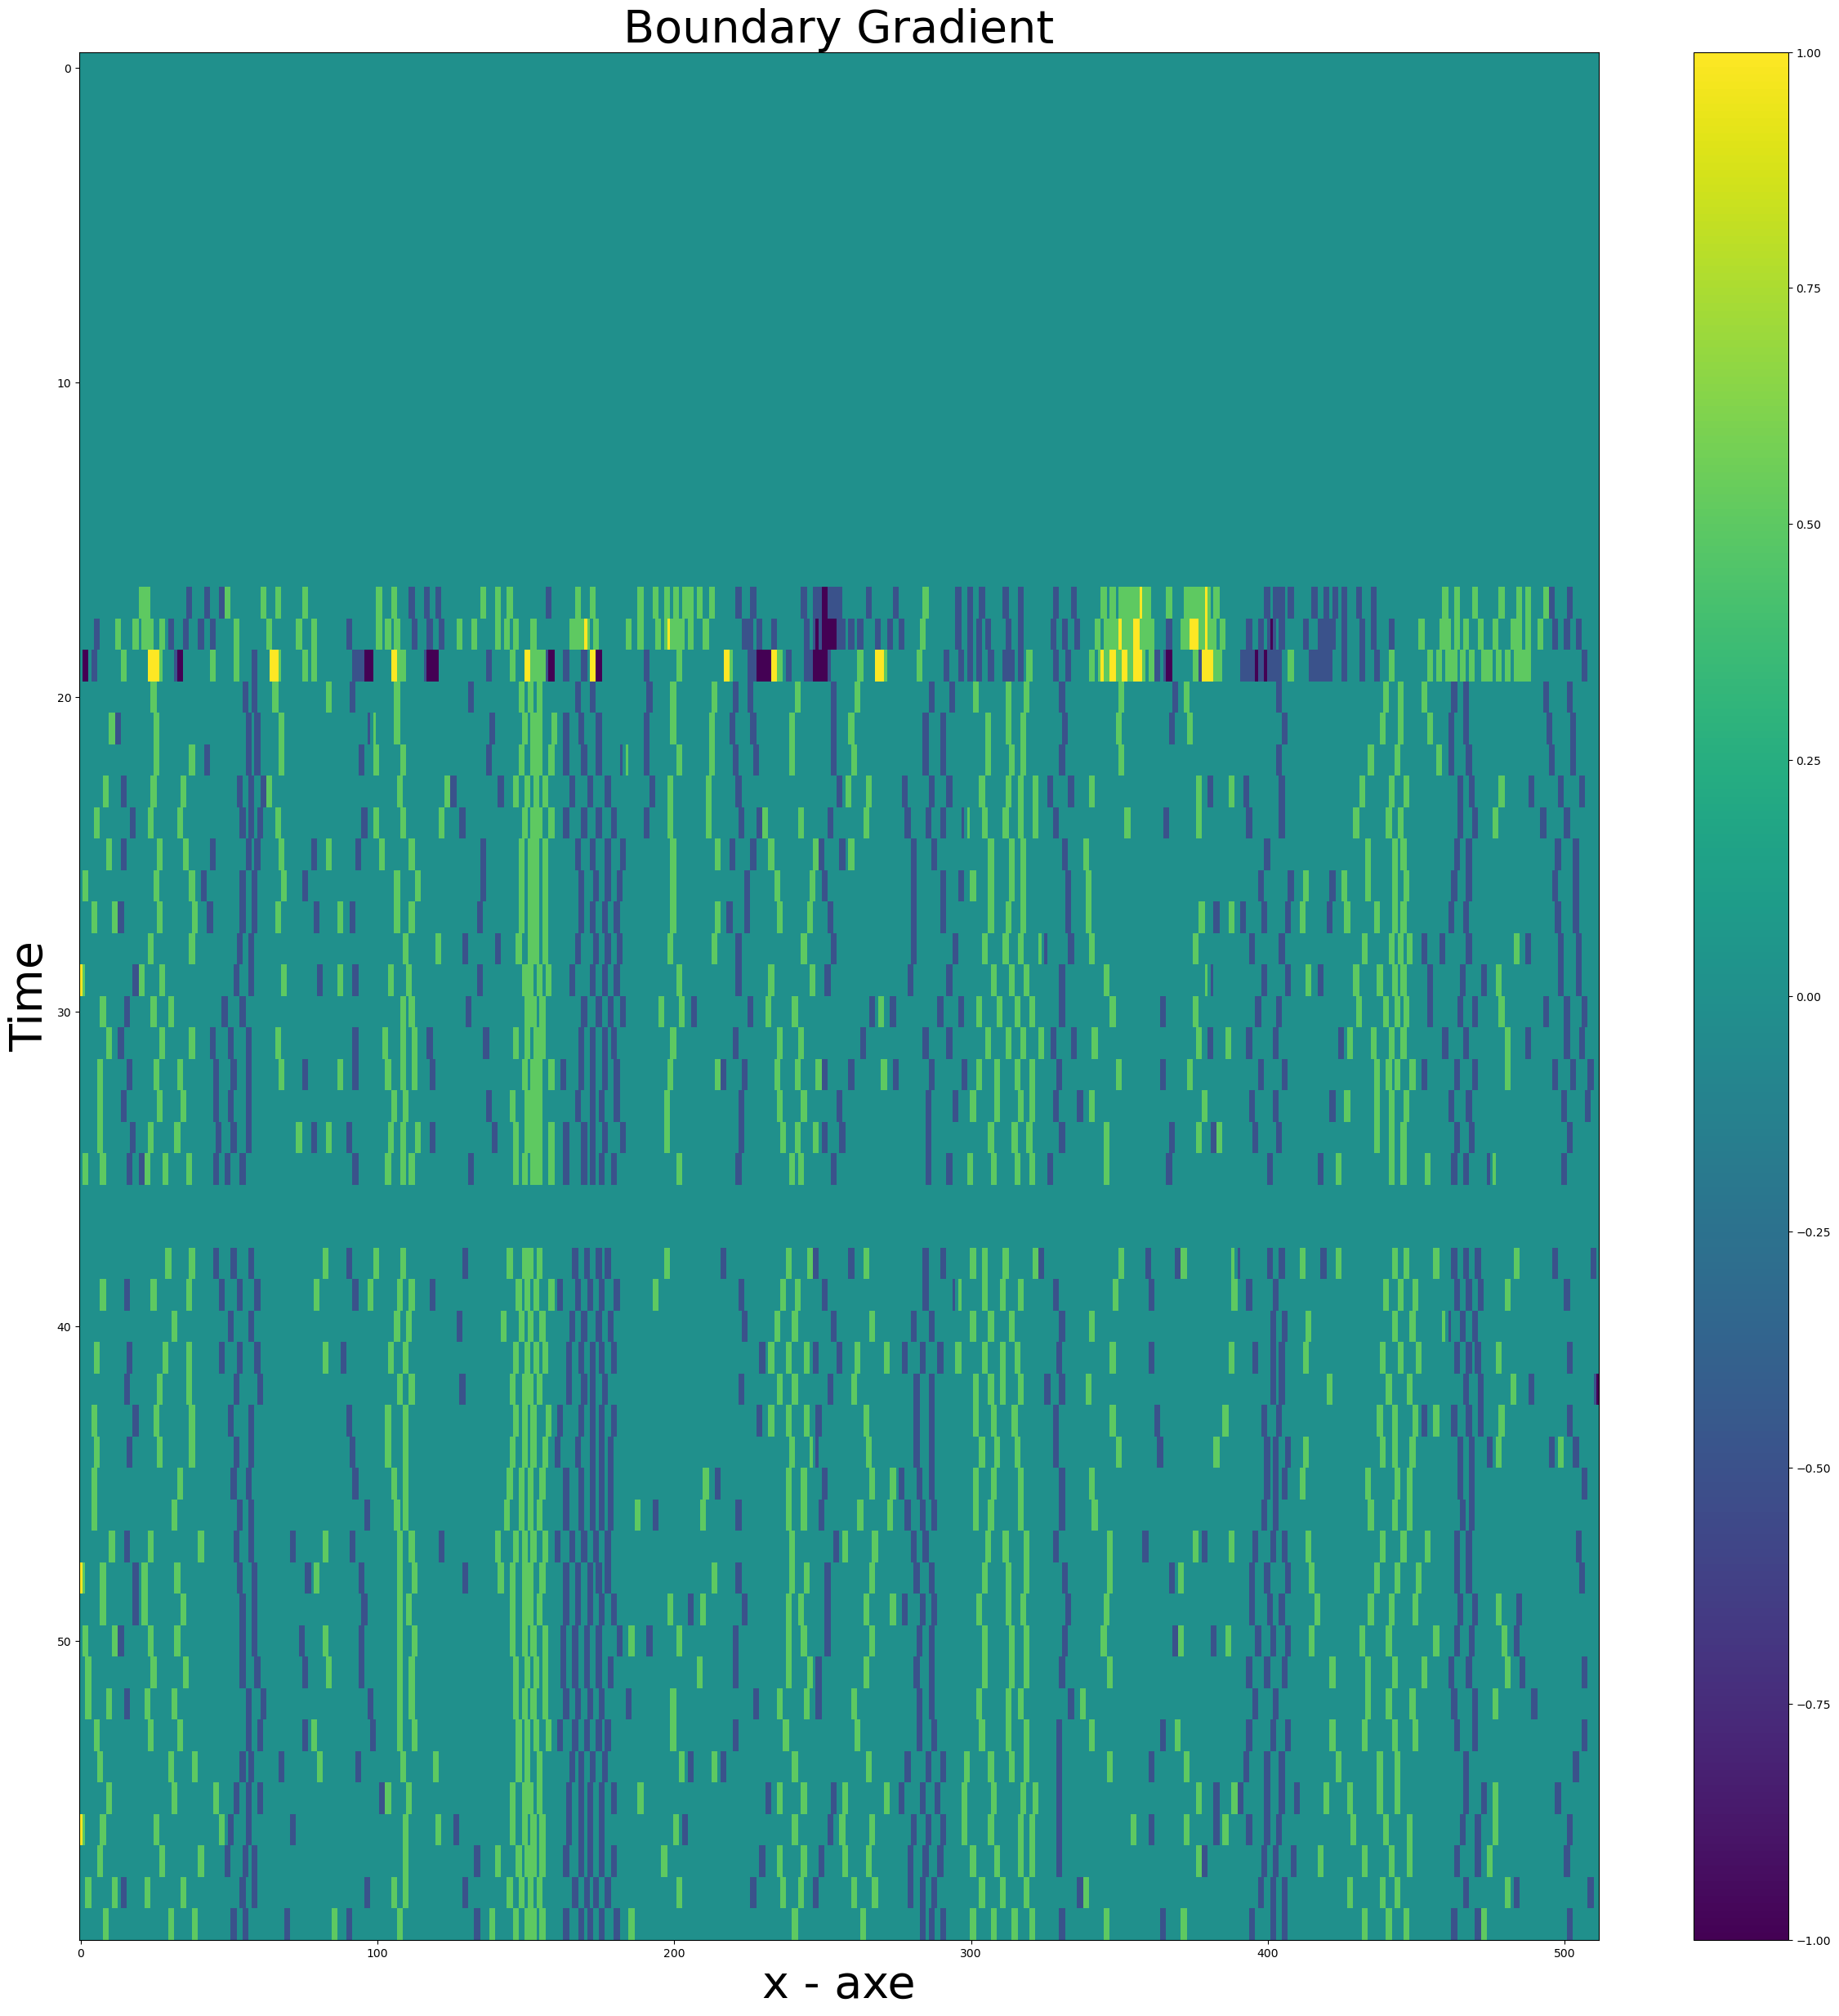

In [62]:
#gradient_table = gradient_table[range(len(gradient_table)-1,0,-1)]
plt.figure(figsize=(30,30))
plt.imshow(gradient_table, vmin= -1, vmax =1, aspect = 'auto')
plt.xlabel('x - axe',  fontsize = 40)
plt.ylabel('Time', fontsize = 40)
plt.title('Boundary Gradient', fontsize = 40)
plt.colorbar()
plt.show()

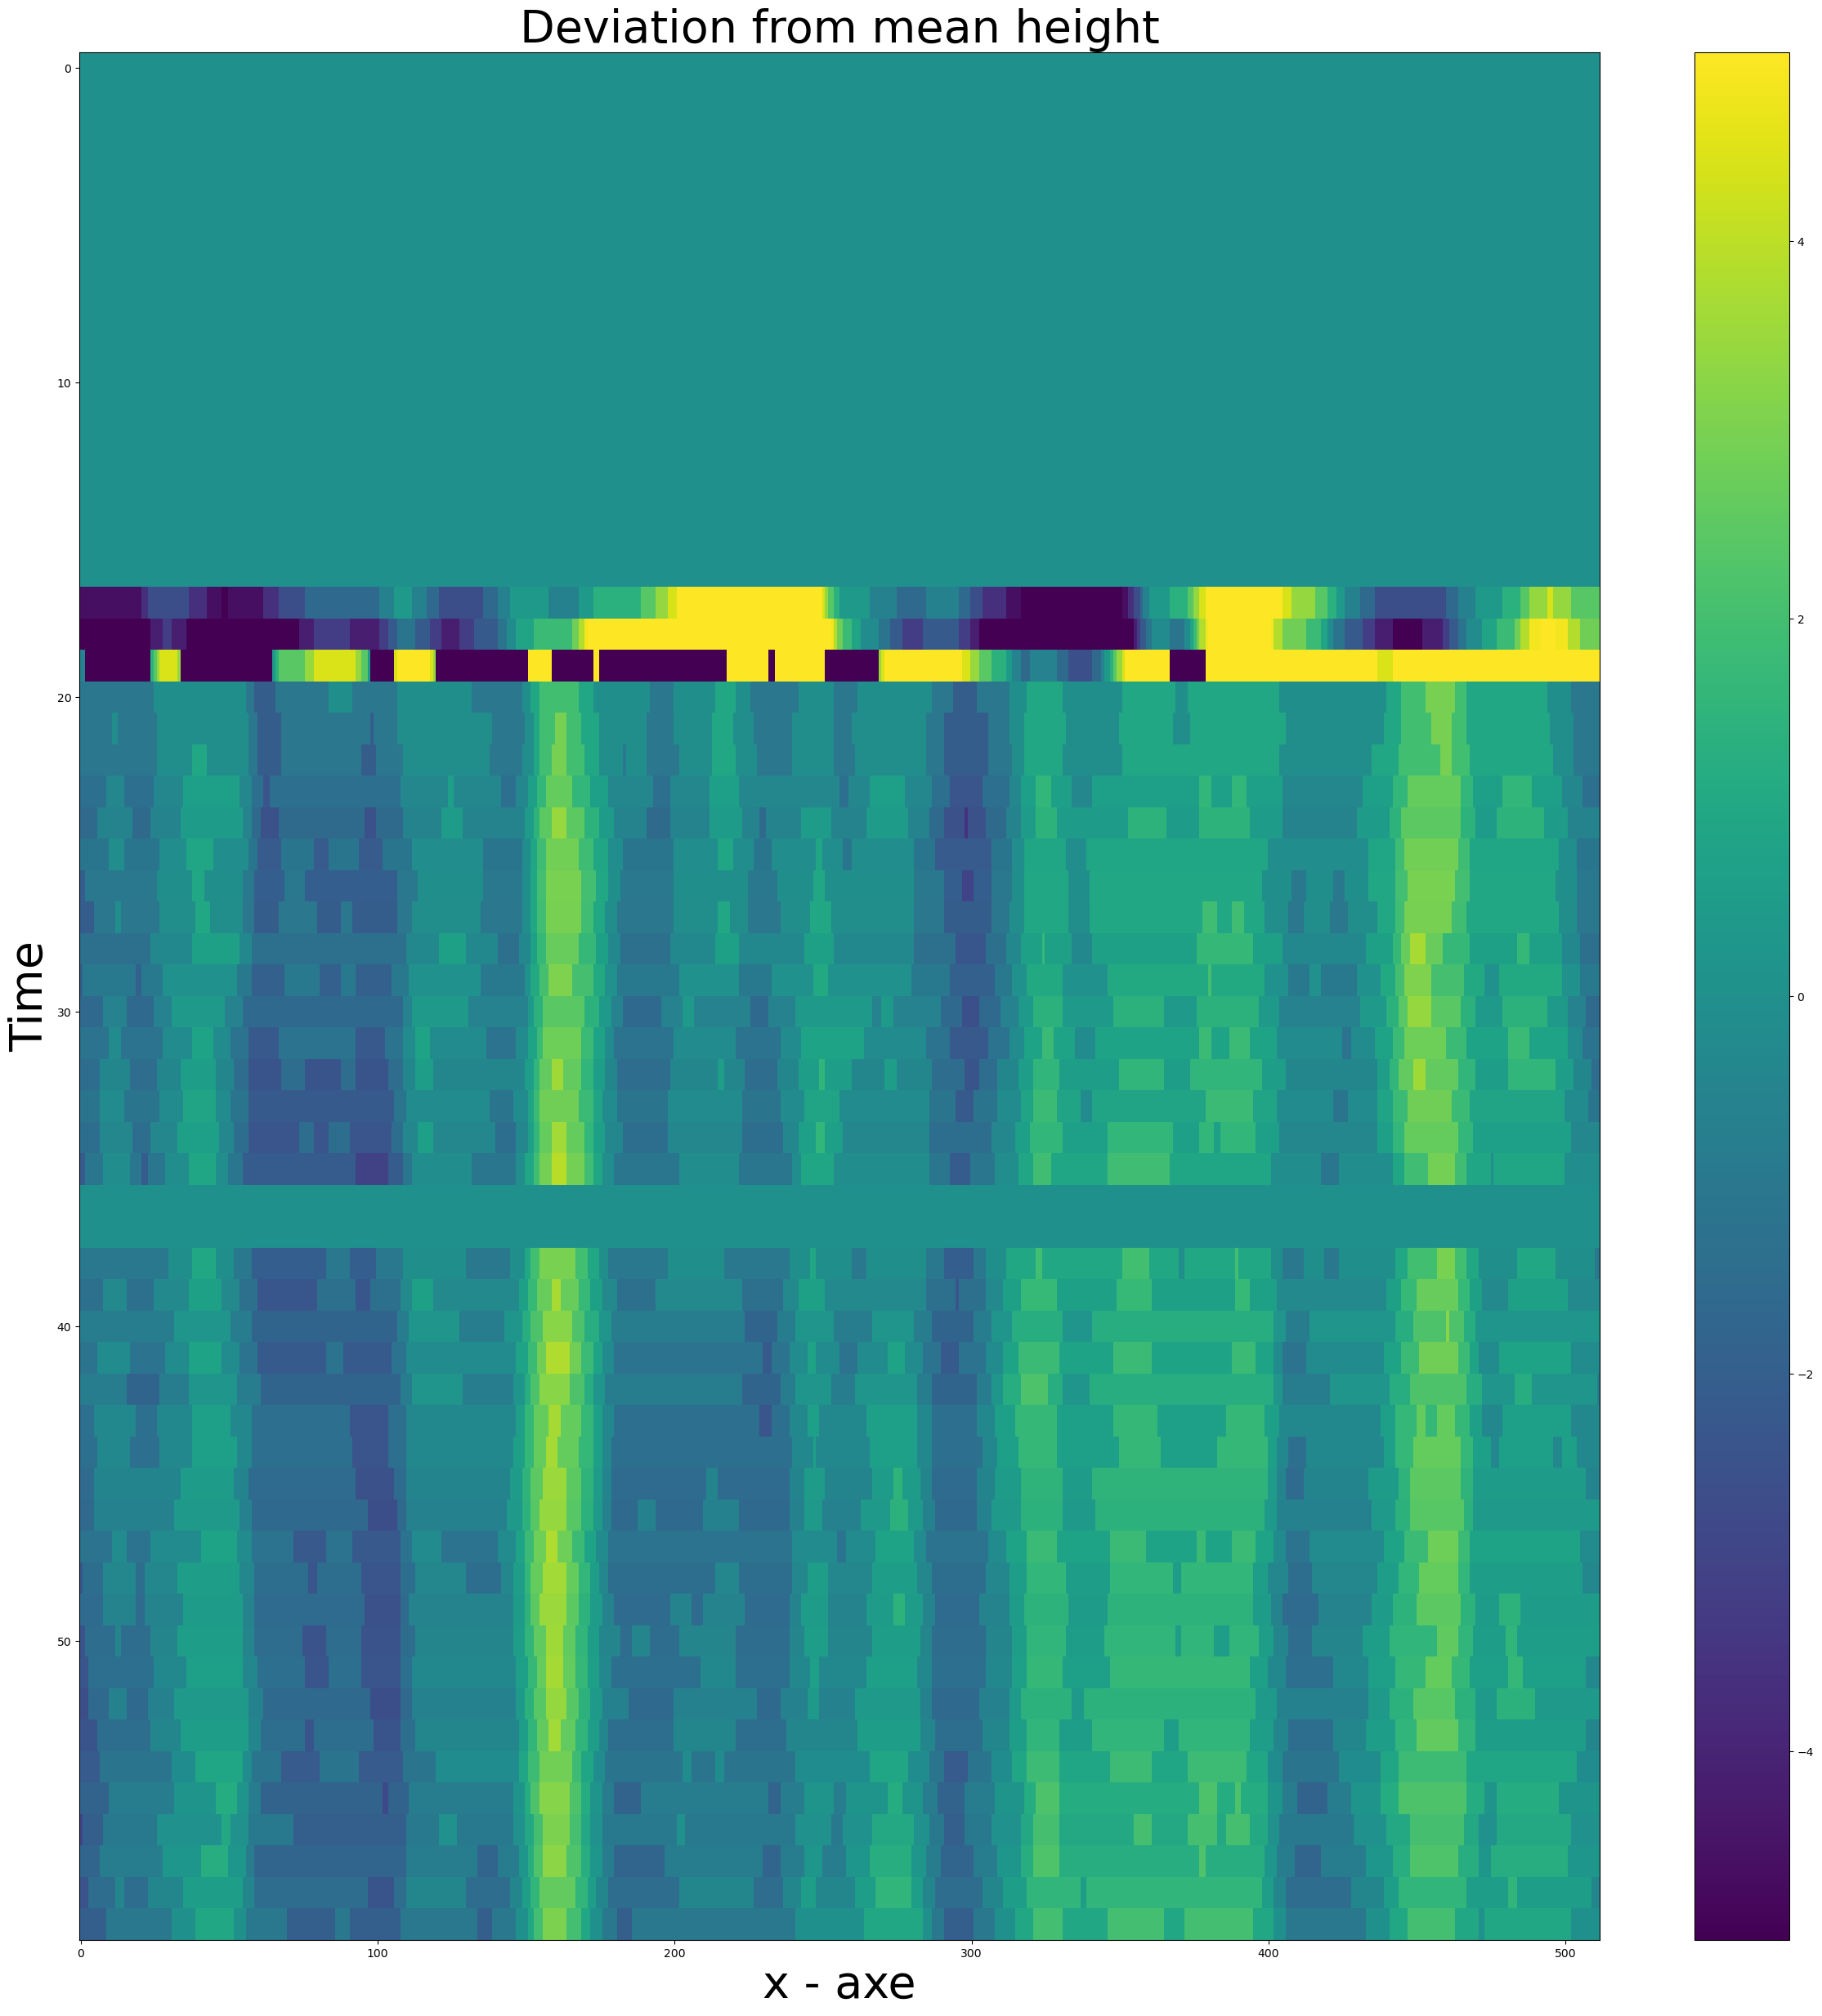

In [60]:
plt.figure(figsize=(30,30))
plt.imshow(height_table, vmin = -5, vmax =5 ,aspect = 'auto')
plt.xlabel('x - axe',fontsize = 40)
plt.ylabel('Time', fontsize = 40)
plt.title('Deviation from mean height',fontsize = 40)
plt.colorbar()
plt.show()

plt.show()

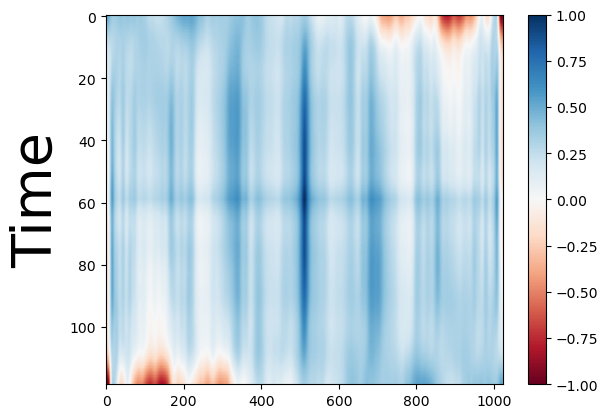

In [68]:
auto = iac.spatial_autocorr(gaussian(gel[:,20,:,256],3), range(160),range(512))
norm_auto = ((auto[0] - auto[0].min())/(auto[0].max() -auto[0].min())-0.5)*2
plt.imshow(norm_auto ,  cmap= cm.get_cmap('RdBu'),aspect = 'auto')
plt.ylabel('Time', fontsize = 40)
plt.colorbar()
plt.show()

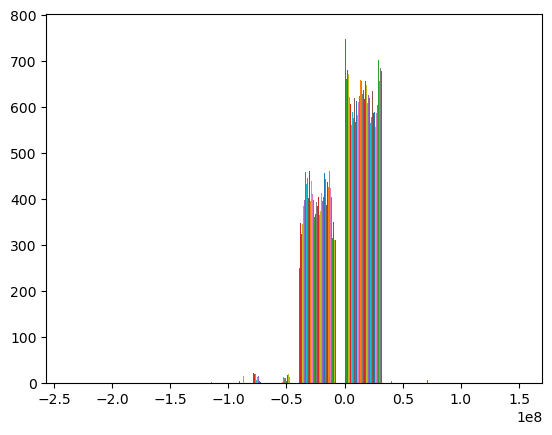

In [7]:
plt.hist(auto[0])
plt.show()

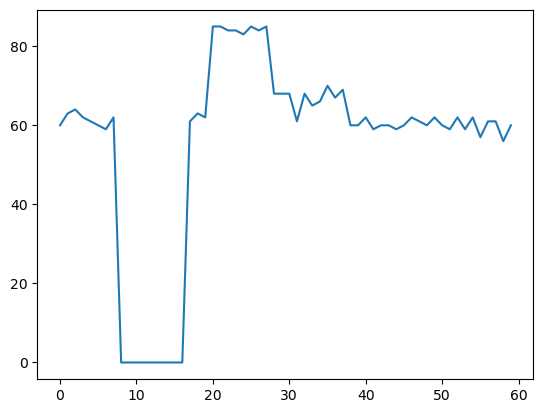

In [16]:
mean_list = []
for t in range(len(gel)):
    mean_list.append((gel[t].min()))
plt.plot(mean_list)
plt.show()

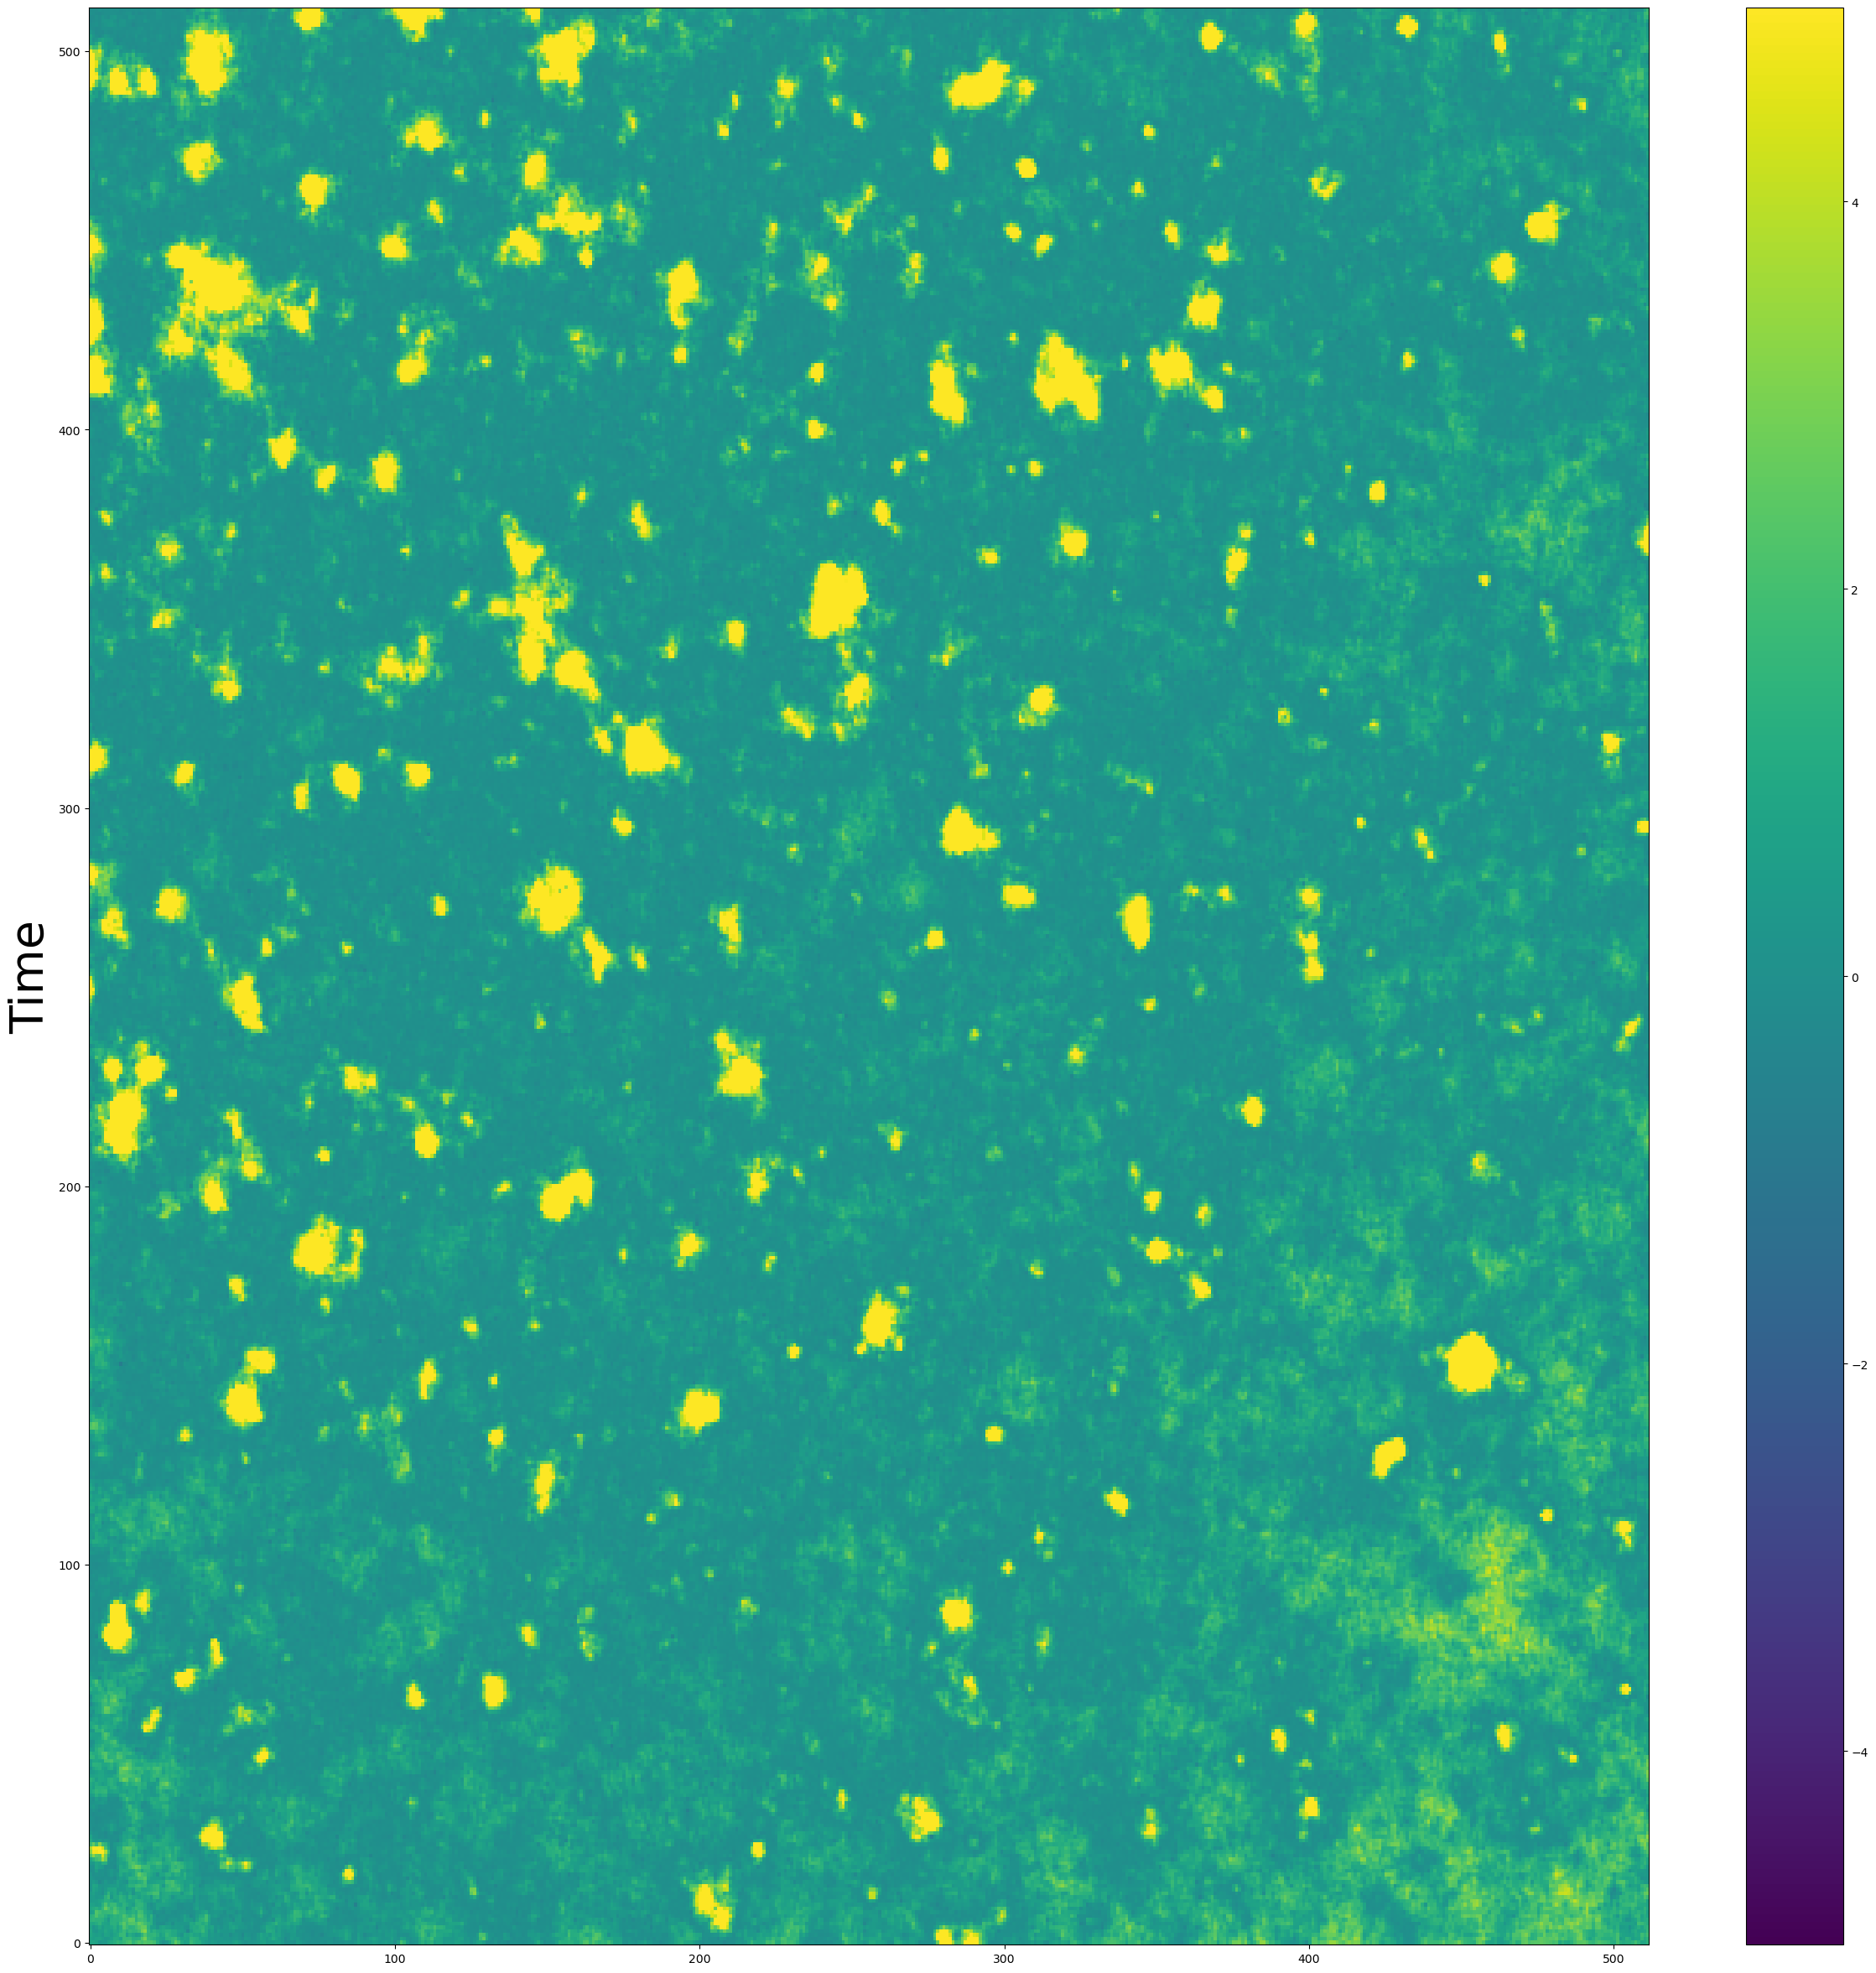

In [71]:
import libpysal

import numpy as np

#np.random.seed(10)
image = gel[20,20,:,:].astype('uint16')
w = libpysal.weights.lat2W(*image.shape)

y = image.reshape(-1,1)

y = np.copy(y)
from esda.moran import Moran_Local

lm = Moran_Local(y, w, transformation = "r", permutations = 99)
output_image = lm.Is.reshape(*image.shape)
plt.figure(figsize=(30,30))
plt.imshow(output_image, vmin =-5, vmax=5, aspect='auto',origin='lower')
plt.ylabel('Time',fontsize = 40)
plt.colorbar()
plt.show()


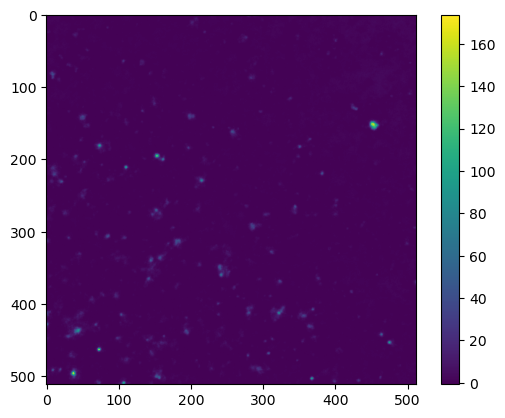

In [72]:
output_image = lm.Is.reshape(*image.shape)
plt.imshow(output_image)
plt.colorbar()
plt.show()


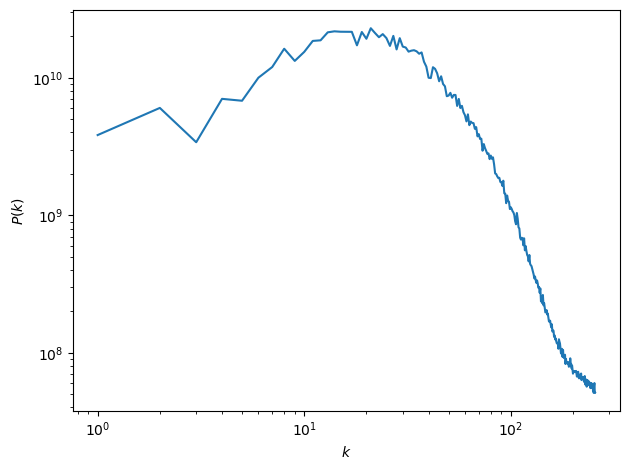

In [73]:
import matplotlib.image as mpimg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as pl

image = output_image.copy()

npix = image.shape[0]

fourier_image = np.fft.fftn(image)
fourier_amplitudes = np.abs(fourier_image)**2

kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)
knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])
Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

pl.loglog(kvals, Abins)
pl.xlabel("$k$")
pl.ylabel("$P(k)$")
pl.tight_layout()
plt.show()